In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy import crs, feature
import xarray as xr
import sys
import cmocean
from salishsea_tools import river_202108 as Rivers
sys.path.append('/users/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *
from math import ceil


cmap = cmocean.cm.deep

fatal: not a git repository (or any of the parent directories): .git


In [2]:
#Load outfall data
Data = pd.read_csv('Sources_Outfalls.csv')
paths = path(1)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
rivers = Rivers.prop_dict

In [3]:
# Crean,Murty, & Stronach, 1988
Rivers = {'Fraser' : {'South':{'coord':[49.123121,-123.252763],'prop':0.85},
                      'North':{'coord':[49.18082742993098, -123.25595425306129],'prop':0.15}},   
                      'Skagit': {'South':{'coord':[coords.nav_lat[213,313].item(),coords.nav_lon[213,313].item()],'prop':0.5},
                                 'North':{'coord':[coords.nav_lat[229,310].item(),coords.nav_lon[229,310].item()],'prop':0.5}}}

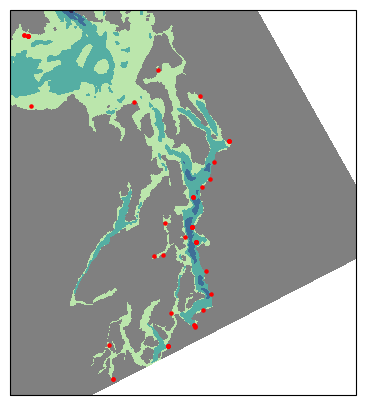

In [4]:
# Make map
blevels = list(np.arange(0,500,100))
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-123.5, -121.5, 47, 48.5], crs=crs.PlateCarree())

im=ax.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,transform=crs.PlateCarree(),cmap=cmap,levels=blevels)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,transform=crs.PlateCarree(),cmap='gray',levels=[-1,0])
plt.scatter(Data['Longitude outfall'],Data['Latitude outfall'],zorder=3,c='r',s=5,transform=crs.PlateCarree())

In [5]:
#Edit table to include Both Skagit and fraser river mouths

pop_deploy = []
lat_deploy = []
lon_deploy = []
outfall_name = []
Depth_deploy = []

for outf in set(Data['Outfall']):
    pop_deploy.append(np.sum(Data[Data['Outfall']== outf].Population))
    outfall_name.append(outf)
    lat_deploy.append(np.array(Data[Data['Outfall']== outf]['Latitude outfall'])[0])
    lon_deploy.append(np.array(Data[Data['Outfall']== outf]['Longitude outfall'])[0])
    Depth_deploy.append(np.array(Data[Data['Outfall']== outf]['Depth'])[0])

skagitindex = outfall_name.index('Skagit')
fraserindex = outfall_name.index('Fraser')

fraser_pop = pop_deploy[fraserindex]
Skagit_pop = pop_deploy[skagitindex]

del pop_deploy[fraserindex]
del pop_deploy[skagitindex]
del lat_deploy[fraserindex]
del lat_deploy[skagitindex]
del lon_deploy[fraserindex]
del lon_deploy[skagitindex]
del outfall_name[fraserindex]
del outfall_name[skagitindex]
del Depth_deploy[fraserindex]
del Depth_deploy[skagitindex]

#Fraser Main
lat_deploy.append(Rivers['Fraser']['South']['coord'][0])
lon_deploy.append(Rivers['Fraser']['South']['coord'][1])
outfall_name.append('Fraser_Main')
pop_deploy.append(Rivers['Fraser']['South']['prop']*fraser_pop)
Depth_deploy.append('River')

#Fraser North
lat_deploy.append(Rivers['Fraser']['North']['coord'][0])
lon_deploy.append(Rivers['Fraser']['North']['coord'][1])
outfall_name.append('Fraser_North')
pop_deploy.append(Rivers['Fraser']['North']['prop']*fraser_pop)
Depth_deploy.append('River')

#Skagit South
lat_deploy.append(Rivers['Skagit']['South']['coord'][0])
lon_deploy.append(Rivers['Skagit']['South']['coord'][1])
outfall_name.append('Skagit_South')
pop_deploy.append(Rivers['Skagit']['South']['prop']*Skagit_pop)
Depth_deploy.append('River')

#Skagit North
lat_deploy.append(Rivers['Skagit']['North']['coord'][0])
lon_deploy.append(Rivers['Skagit']['North']['coord'][1])
outfall_name.append('Skagit_North')
pop_deploy.append(Rivers['Skagit']['North']['prop']*Skagit_pop)
Depth_deploy.append('River')

Outfall_deploy = {'Name':outfall_name,'Lat':lat_deploy,'Lon':lon_deploy,'Population':pop_deploy,'Depth':Depth_deploy}
Outfall_deploy = pd.DataFrame(data=Outfall_deploy)


In [6]:
Outfall_deploy.to_csv('/Users/jvalenti/MOAD/analysis-jose/notebooks/Deploy_files/Outfall_deploy.csv')

In [7]:
D = []
for d in Depth_deploy:
    if d =='River':
        D.append(2)
    else:
        D.append(float(d))

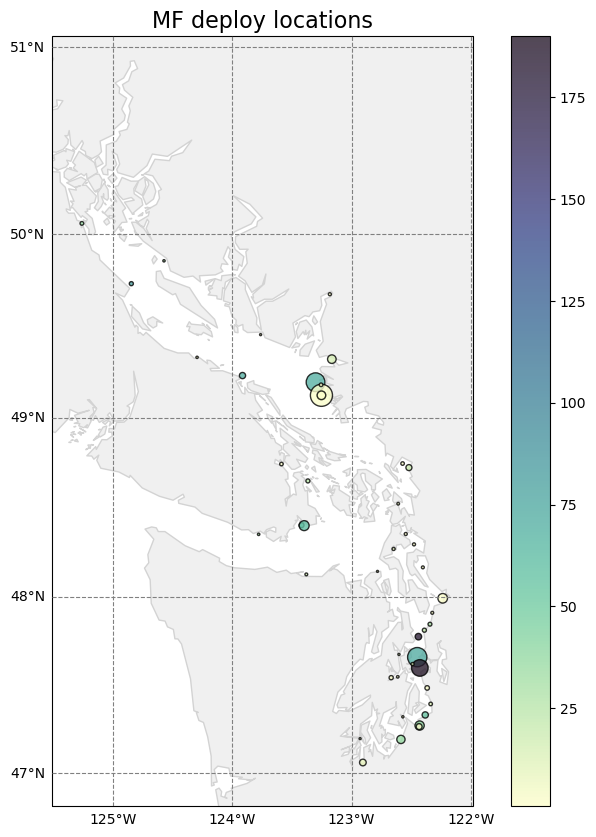

In [8]:
lonmin= Outfall_deploy.Lon.min()-0.25
lonmax= Outfall_deploy.Lon.max()+0.25
latmin= Outfall_deploy.Lat.min()-0.25
latmax= Outfall_deploy.Lat.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('MF deploy locations',fontsize='16')
sc=plt.scatter(Outfall_deploy.Lon,Outfall_deploy.Lat,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Outfall_deploy.Population/5e3,c=D,cmap=cmocean.cm.deep,edgecolors= "k")
plt.colorbar(sc)

In [40]:
def pandas_deploy(N,MFc,r,dd,dtp):
    #r is radius of particle cloud [m]
    MFc = float(MFc)
    Outfall_deploy = pd.read_csv(N, index_col = [0])
    Pol = list(Outfall_deploy.Population)
    Lat = Outfall_deploy.Lat
    Lon = Outfall_deploy.Lon
    Depth = Outfall_deploy.Depth
    clat = []
    clon = []
    cz = []
    for i,loc in enumerate(Pol):
        for j in range(int(round((loc*250*dtp)/MFc,0))):
            clat.append(Lat.iat[i])
            clon.append(Lon.iat[i])
            try:
                cz.append(float(Depth.iat[i]))
            except ValueError:
                cz.append(2)
    N = len(clat)
    deg2m = 111000 * np.cos(49 * np.pi / 180)
    var = (r / (deg2m * 3))**2
    x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
    z_offset=np.random.random_sample([N]).T*(dd)
    lon = np.zeros([N])
    lat = np.zeros([N])
    z = np.zeros([N])
    for i in range(N):
        lon[i]=(clon[i] + x_offset[i])
        lat[i]=(clat[i] + y_offset[i])
        z[i]=(cz[i] + z_offset[i])
    return lon,lat,z

In [43]:
N = '/Users/jvalenti/MOAD/analysis-jose/notebooks/Deploy_files/Outfall_deploy.csv'
n = 1
MFc = 1e6
r = 250
dd = 2
dtp = 10
lon, lat, z = pandas_deploy(N,MFc,r,dd,dtp)